## Different used imports

In [1]:
import os
import copy
import warnings

from datetime import datetime
import time

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import pandas
import geopandas

import pysal as ps
import libpysal as lps

from shapely.geometry import Point

from skgstat import Variogram

import pwlf

C:\Users\gabin\Anaconda3\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\gabin\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Read different data

### 1. Dates (not used)

In [2]:
def prepareModisDates(modisPath):
    """
        Recover *r.file.date.txt file dates in a chronological sorted list.
        This file contains MODIS passages over Ireland.
        
        :param modisPath: path to the file from browseFiles()
        :type modisPath: str
        
        :return: list of each MODIS passages
        :rtype: list(str, datetime.datetime, ...)
    """
    dates = []
    
    datePath = '/'.join(modisPath.split('/')[:-1:])
    
    for file in os.listdir(datePath):
        if file[-15::] == 'r.file.date.txt':
            datePath += '/' + file
            dateFile = open(datePath, 'r')
            
            for line in dateFile.readlines():
                if len(dates) == 0:
                    dates.append('date')
                else:
                    line = line.replace('\n', '')
                    line = line.split(' ')
                    dates.append(datetime.strptime(line[1], '%Y-%m-%d'))
    
    header = dates[0]
    dates = sorted(dates[1::])
    dates.insert(0, header)
    
    return dates

### 2. Quadrats information

In [3]:
def prepareQuadratsData(quadratsCoordPath):
    """
        Read a .txt file to recover ITM coordinates of quadrats : QuadratsCoordinates.txt.
        These translations were made with https://irish.gridreferencefinder.com/.
        
        :param quadratsCoordPath: path to the file
        :type quadratsCoordPath: str
        
        :return: list with a header containing quadrat's id and x and y coordinates in ITM
        :rtype: list(list, ..., list)
    """
    quadratsFile = open(quadratsCoordPath, 'r')
    
    quadratsData = []
    
    for line in quadratsFile.readlines():
        
        line = line.replace('\n', '')
        line = line.split(' ')
        
        if len(quadratsData) != 0:
            line[0] = int(line[0])
            line[1] = float(line[1])
            line[2] = float(line[2])
        
        quadratsData.append(line)
    
    quadratsFile.close()
    
    return quadratsData

In [4]:
quadratsCoordPath = 'QuadratsCoordinates.txt'
quadratsCoordData = prepareQuadratsData(quadratsCoordPath)

print ("There isn't all quadrats in this file.")
print (quadratsCoordData)

There isn't all quadrats in this file.
[['id', 'xITM', 'yITM'], [1, 717441.0, 757122.0], [2, 688768.0, 622410.0], [3, 720116.0, 684104.0], [4, 613449.0, 700127.0], [5, 592001.0, 743673.0], [6, 624473.0, 638858.0], [7, 646147.0, 797444.0], [8, 629598.0, 778495.0], [9, 644922.0, 746673.0]]


### 3. MODIS measurements

That was at the beginning of the intern and I did not know pandas library.
It might be possible to go from arrays to DataFrame to improve processing times.

In [5]:
def prepareModisData(modisPath):
    """
        Read a .txt file to recover MODIS data pre-processed with phenograss_process_MODIS_v2.R
        by Jon Yearsley. The output is an array sorted by chronological order.
        
        :param modisPath: path to the file
        :type modisPath: str
        
        :return: array containing MODIS data
        :rtype: numpy.ndarray
    """
    modisFile = open(modisPath, 'r')
    modisData = []
    
    for line in modisFile.readlines():
        
        line = line.replace('"',  '')
        line = line.replace('\n', '')
        line = line.split(' ')
        
        if len(modisData) == 0:
            line.insert(0, 'id')
        else:
            line[0] = int(line[0])
            line[1] = float(line[1])
            line[2] = float(line[2])
            line[3] = float(line[3])
            line[4] = float(line[4])
            line[6] = int(line[6])
            line[7] = int(line[7])
            line[8] = int(line[8])
            line[9] = float(line[9])
            line[10] = float(line[10])
            line[11] = int(line[11])
            line[12] = datetime.strptime(line[12], '%Y-%m-%d')
            
        modisData.append(line)
        
    modisFile.close()
    
    header = modisData[0]
    modisData = sorted (modisData[1::], key=lambda day: day[8])
    modisData = np.insert(modisData, 0, header, axis=0)
    
    return modisData

In [6]:
def squareData(modisData):
    """
        If prepareModisData() is used and results are 'append' in a same list ex. list(MODIS_2017, MODIS_2018), 
        that's possible to concatenate MODIS data with this function.
        
        :param modisData: several MODIS year data
        :type modisData: list[list[MODIS data for year X], [MODIS data for year (X+1)], ...]
        
        :return: MODIS data reformatted and the number of years of data
        :rtype: tuple(list, int)
    """
    copyModisData = copy.deepcopy(modisData)
    for data in copyModisData:
        try:
            if len(globalModisData) > 0:
                data = data[1::]
                data[:,8] = data[:,8] + (nbYears * 365)
                globalModisData = np.concatenate((globalModisData, data), axis=0)
                nbYears += 1
        except NameError:
            globalModisData = data
            nbYears = 1
    
    return globalModisData, nbYears

In [7]:
squareFilePaths = ["modis_pasture_A2013_square1_d_sq.txt",
                   "modis_pasture_A2014_square1_d_sq.txt",
                   "modis_pasture_A2015_square1_d_sq.txt",
                   "modis_pasture_A2016_square1_d_sq.txt",
                   "modis_pasture_A2017_square1_d_sq.txt"]

squareModisData = []

for filePath in squareFilePaths:
    modisData = prepareModisData(filePath)
    squareModisData.append(modisData)

print (squareData(squareModisData))

(array([['id', 'x_ITM', 'y_ITM', ..., 'ndvi', 'QC', 'date'],
       [99616, 714114.068877104, 756595.495285772, ..., 0.6189, 1,
        datetime.datetime(2013, 1, 2, 0, 0)],
       [105519, 717857.683953661, 756455.565933358, ..., 0.7124, 1,
        datetime.datetime(2013, 1, 2, 0, 0)],
       ...,
       [181035, 713912.47234178, 752183.961850394, ..., 0.6213, 1,
        datetime.datetime(2017, 12, 27, 0, 0)],
       [182741, 717862.346898622, 752280.817223724, ..., 0.7633, 1,
        datetime.datetime(2017, 12, 27, 0, 0)],
       [182842, 718094.69131406, 752286.617449876, ..., 0.7664, 1,
        datetime.datetime(2017, 12, 27, 0, 0)]], dtype=object), 5)


## Filter MODIS data to keep one date (with most values) for each months to avoid working on each dates

In [8]:
def monthlyModisData(modisData):
    """
        Filter MODIS data to keep the day with the most measurements for each month.
        
        :param modisData: MODIS data from prepareModisData()
        :type modisData: numpy.ndarray
        
        :return: filtered MODIS data (xMODIS, yMODIS, ndvi, evi, forMonth)
        :rtype: tuple(list, list, list, list, list)
    """    
    transpose = modisData[1::].T
    doy, evi, ndvi = transpose[8], transpose[9], transpose[10]
    quality = transpose[11]
    xMODIS, yMODIS = transpose[3], transpose[4]
    
    doyShade = {}
    
    # doyShade = {day of the year: [appearance indices, ...], ...}
    for i in range (len(doy)):
        key = doy[i]
        
        if key in doyShade:
            indexes = doyShade[key]
            indexes.append(i)
            doyShade[key] = indexes
        else:
            doyShade[key] = [i]
            
    doyShade = sorted(doyShade.items(), key=lambda num: len(num[1]), reverse=True)    
    
    # For each month, keep the date with the most values
    forMonth, year = [], transpose[7][1]
    for i in range (1, 13):
        for couple in doyShade:
            date = datetime.strptime('{}-{}'.format(str(year),str(couple[0])), '%Y-%j')
            if int(date.strftime('%m')) == i:
                                
                # Also take values of day before and after if exists
                for j in range (len(doyShade)):
                    if doyShade[j][0] == (couple[0] - 1):
                        temp = doyShade[j][1]
                    elif doyShade[j][0] == (couple[0] + 1):
                        try:
                            temp += doyShade[j][1]
                        except UnboundLocalError:
                            temp = doyShade[j][1]
                
                coords = []
                for index in couple[1]:
                    coords.append((xMODIS[index], yMODIS[index]))
                
                keepIndexes = []
                
                try:
                    for k in range (len(temp)):
                        if (xMODIS[temp[k]], yMODIS[temp[k]]) not in coords:
                            keepIndexes.append(temp[k])
                except UnboundLocalError:
                    pass
                
                for index in keepIndexes:
                    coords.append((xMODIS[index], yMODIS[index]))
                
                indCouple = couple[1] + keepIndexes
                
                removeIndexes = []
                for i in range (len(indCouple)):
                    for j in range (i+1, len(indCouple)):
                        if coords[i] == coords[j]:
                            if quality[i] < quality[j]:
                                removeIndexes.append(j)
                            elif quality[j] < quality[i]:
                                removeIndexes.append(i)
                
                removeIndexes = sorted(set(removeIndexes), reverse=True)
                
                for index in removeIndexes:
                    del coords[index]
                    del indCouple[index]
                
                treatedCoords = []
                finished = False
                
                while finished == False:
                    finished = True
                    for i in range (len(indCouple)):
                        if coords[i] in treatedCoords:
                            continue
                        else:
                            treatedCoords.append(coords[i])
                            indSame = []
                            for j in range (i+1, len(indCouple)):
                                if coords[i] == coords[j]:
                                    indSame.append(j)
                                                    
                            if len(indSame) > 0:
                                finished = False
                                
                                ndviAverage, eviAverage = evi[indCouple[i]], ndvi[indCouple[i]]
                                
                                for k in indSame:
                                    ndviAverage += ndvi[indCouple[k]]
                                    eviAverage += evi[indCouple[k]]
                                ndviAverage /= (len(indSame) + 1)
                                eviAverage /= (len(indSame) + 1)
                                
                                for k in reversed(indSame):
                                    del indCouple[k]
                                    del coords[k]
                                
                                ndvi[i] = ndviAverage
                                evi[i] = eviAverage
                                
                                break
                            
                forMonth.append((date.strftime('%m-%d-%Y'), indCouple))
                
                # Just take the first result for each month because the list is sorted
                break
    
    return xMODIS, yMODIS, ndvi, evi, forMonth

In [9]:
filteredModisData = monthlyModisData(modisData)

print ('Conserved dates: {}'.format(np.array(filteredModisData[4], dtype=object)[:,0]))

Conserved dates: ['01-23-2017' '02-05-2017' '03-24-2017' '04-08-2017' '05-08-2017'
 '06-17-2017' '07-18-2017' '08-30-2017' '09-18-2017' '10-02-2017'
 '11-12-2017' '12-27-2017']


## Look at time series

### 1. On the entire quadrat

In [10]:
def simpleGraph(modisData, method, threshold):
    """
        Use MODIS data to plot NDVI and EVI measures in a year.
        There are graphics with every measures beside one with the average of measures
        on each days.
        
        :param modisData: MODIS data from prepareModisData()
        :param method: 'year' or 'square' for the x axis of graphs
        :param threshold: the minimum number of measurements on a day to take it in consideration
        :type modisData: numpy.ndarray
        :type method: str
        :type threshold: int
    """
    # Treatment
    if method == 'year':
        nbYears = 1
    
    elif method == 'square':
        modisData, nbYears = squareData(modisData)
        
    for process in ['all', 'QC = 0', 'QC = 1']:
        
        transpose = copy.deepcopy(modisData[1::])
        
        if process == 'QC = 0':
            for i in (np.arange(len(transpose)-1, -1, -1)):
                if transpose[i][11] != 0:
                    transpose = np.delete(transpose, i, axis=0)
        
        if process == 'QC = 1':
            for i in (np.arange(len(transpose)-1, -1, -1)):
                if transpose[i][11] != 1:
                    transpose = np.delete(transpose, i, axis=0)
        
        transpose = transpose.T
        doy, evi = transpose[8], transpose[9]
        doyAverage, eviAverage = sorted(set(doy)), []
        eviMax, eviMin = [], []
        
        # count = {day in the year: number of occurrences, ...}
        count = {}.fromkeys(doyAverage,0)
        for value in doy:
            count[value] += 1
        
        index = 0
        for key,value in count.items():
            
            if value > threshold:
                eviSum = 0
                
                for i in range (value):
                    i += index
                    
                    eviSum += evi[i]
                
                eviAverage.append(eviSum/value)
                
                eviMax.append(max(evi[index:value+index:]))
                eviMin.append(min(evi[index:value+index:]))
                
            else:
                doyAverage.remove(key)
                
            index += value
        
        # Graphics
        fig = plt.figure(figsize=(12,6))
        
        plt.suptitle("Quadrat's MODIS EVI ({})".format(process),
                     size='xx-large', weight='bold', y=0.96)
        
        plt.subplot(121)
        plt.plot(doy, evi, 'b.', markersize=3)
        plt.xlabel("Year's day", size='large', style='italic')
        plt.xlim(0,365*nbYears)
        plt.ylabel('EVI', size='large', style='italic')
        plt.ylim(0,1)
        plt.grid()
        
        plt.subplot(122)
#        plt.plot(doyAverage, eviMax, 'r:o', markersize=3, linewidth=1, label='max')
        plt.plot(doyAverage, eviAverage, 'g:o', markersize=3, linewidth=1, label='average')
#        plt.plot(doyAverage, eviMin, 'b:o', markersize=3, linewidth=1, label='min')
        plt.legend(loc='upper right', framealpha=0.8)
        plt.xlabel("Year's day", size='large', style='italic')
        plt.xlim(0,365*nbYears)
        plt.ylabel('EVI', size='large', style='italic')
        plt.ylim(0,1)
        plt.grid()
        
        plt.show()
        
        print ('\n\n')

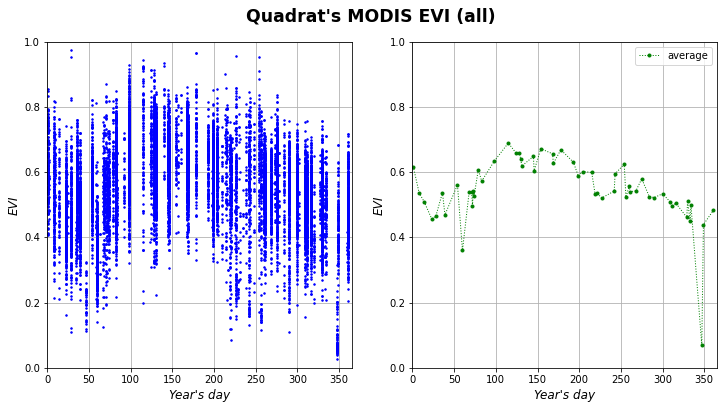

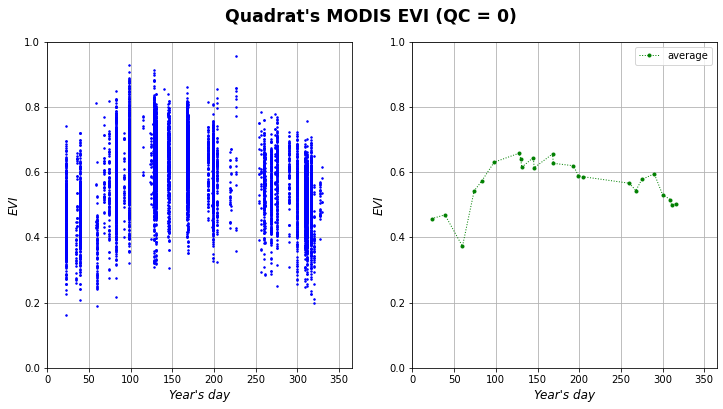

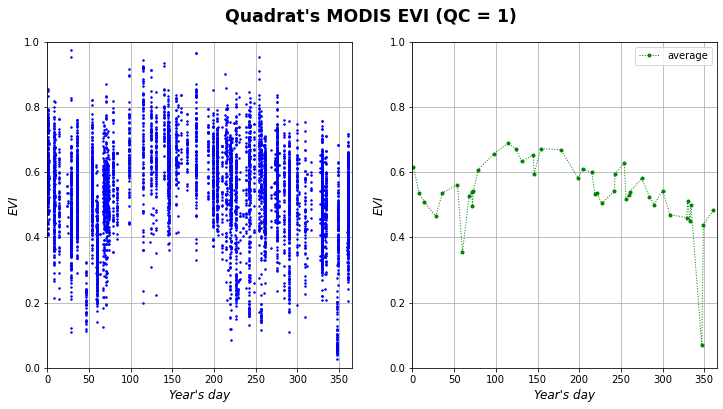

In [11]:
simpleGraph(modisData, 'year', 50)

### 2. On some pixels

In [12]:
def loc(coordMODIS):
    """
        Return a dict with appearance indices of each coordinates.
        
        :param coordMODIS: an array with all coordinates
        :type coordMODIS: numpy.ndarray((float, float), ...)
        
        :return: {(xMODIS,yMODIS): [an appearance indice, another one, ...], ...}
        :rtype: dict
    """
    location = {}
    
    for i in range (len(coordMODIS)):
        key = (coordMODIS[i,0], coordMODIS[i,1])
        
        if key in location:
            indexes = location[key]
            indexes.append(i)
            location[key] = indexes
        else:
            location[key] = [i]
    
    return location

In [13]:
transpose = modisData[1::].T
xMODIS, yMODIS = transpose[3], transpose[4]
coordMODIS = np.array([xMODIS,yMODIS]).T

print (loc(coordMODIS))

{(-413854.084038562, 5959475.64451746): [0, 507, 977, 1325, 1790, 2257, 2332, 3460, 3689, 4105, 4537, 4998, 5664, 6290, 6458, 7267, 7736, 7852, 8314, 8760, 9218, 9564, 10017, 10271, 10629, 11207, 11378, 11981, 12242, 13002, 13468, 13547, 13666, 14324, 14697, 15192, 15715, 16670, 16820, 17092], (-413622.427680298, 5959475.64451746): [1, 508, 978, 1326, 1791, 2217, 2634, 3461, 3690, 4106, 4538, 4999, 5665, 6291, 6459, 7268, 7737, 7853, 8315, 8761, 9565, 10018, 10272, 10630, 11119, 11208, 11497, 11982, 12243, 13003, 13469, 13548, 13667, 14325, 14698, 15193, 15706, 15716, 16588, 16671, 16821, 17093], (-413390.771322034, 5959475.64451746): [2, 509, 979, 1327, 1792, 2218, 2635, 3462, 3691, 4107, 4539, 5000, 5666, 6292, 6460, 7269, 7738, 7854, 8316, 8762, 9566, 10019, 10273, 10631, 11120, 11209, 11498, 11983, 12244, 13004, 13470, 13549, 13668, 14326, 14699, 15194, 15707, 15717, 16589, 16672, 16822, 17094], (-412695.802247242, 5959475.64451746): [3, 512, 982, 1330, 1795, 2638, 3021, 3102, 3694

In [14]:
def perPixel(modisData, nbSeriesToShow, method):
    """
        Use MODIS data to plot NDVI and EVI time series for each pixel.
        The most measured pixels are printed first.
        
        :param modisData: MODIS data from prepareModisData()
        :param nbSeriesToShow: the number of desired graphics
        :param method: 'year' or 'square' for the x axis of graphs
        :type modisData: numpy.ndarray
        :type nbSeriesToShow: int
        :type method: str
    """
    # Treatment
    if method == 'year':
        nbYears = 1
    
    elif method == 'square':
        modisData, nbYears = squareData(modisData)
    
    transpose = modisData[1::].T
    xMODIS, yMODIS = transpose[3], transpose[4]
    coordMODIS = np.array([xMODIS,yMODIS]).T
    
    location = loc(coordMODIS)
    
    if method == 'year':
        year = transpose[7][0]
        monthDelimitations, midMonth, months = [], [], []
        
        for month in np.arange(1,13,1):
            monthDelimitations.append(int(datetime.strftime
                    (datetime.strptime('{}-1-{}'.format(month,year), '%m-%d-%Y'), '%j')))
            midMonth.append(int(datetime.strftime
                    (datetime.strptime('{}-15-{}'.format(month,year), '%m-%d-%Y'), '%j')))
            months.append(datetime.strftime(datetime.strptime(str(month), '%m'), '%b'))
        monthDelimitations.append(int(datetime.strftime
                    (datetime.strptime('12-31-{}'.format(year), '%m-%d-%Y'), '%j')))
    
    # Keep coordinates with the most measures
    location = sorted(location.items(), key=lambda num: len(num[1]), reverse=True)[:nbSeriesToShow:]
        
    for count in location:
        
        key, value = count[0], count[1]
        name = '{}_{}_{}'.format(len(value),key[0],key[1])        
        
        doy, evi = [], []
        
        for index in value:
            doy.append(transpose[8][index])
            evi.append(transpose[9][index])
        
        # Graphics
        fig = plt.figure(figsize=(12,5))
        plt.suptitle('Time series analysis', size='xx-large', weight='bold', y=0.95)
        
        plt.plot(doy, evi, 'b:o', markersize=3, label='Raw data')
        plt.legend(loc='upper right', framealpha=0.8)
        plt.xlabel("Year's day", size='large', style='italic')
        plt.xlim(1,nbYears*365)
        plt.ylabel('EVI', size='large', style='italic')
        plt.ylim(0,1)
        plt.grid()
        
        try:
            axes = plt.gca()
            
            axes.xaxis.set_ticks(monthDelimitations)
            axes.xaxis.set_tick_params(length=15)
            axes.xaxis.set_ticklabels([''])
            
            axes.xaxis.set_ticks(midMonth, minor=True)
            axes.xaxis.set_tick_params(length=0, which='minor')
            axes.xaxis.set_ticklabels(months, minor=True)
            
            plt.xlabel("Months", size='large', style='italic')
        except NameError:
            pass
                
        plt.show()
        
        print ('\n\n')

2 pixels for 2017


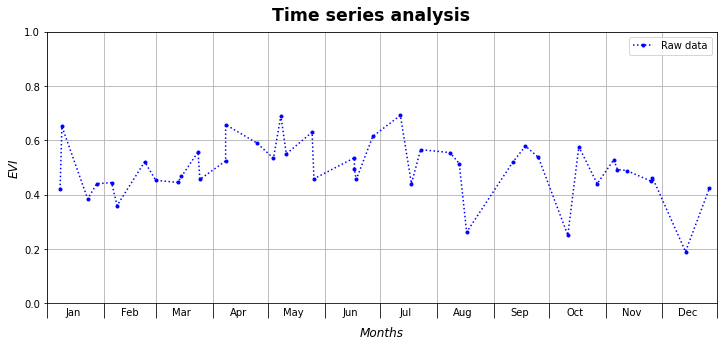

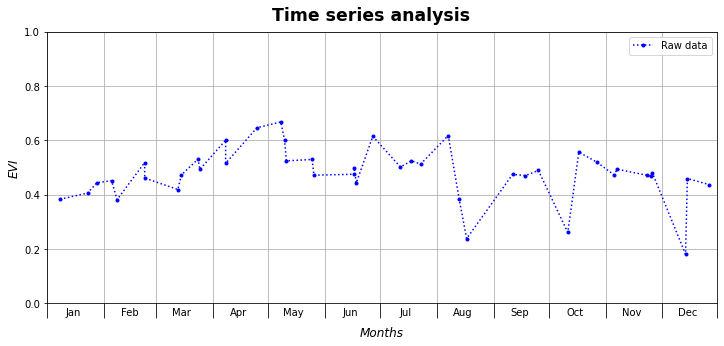




2 pixels from 2013 to 2017


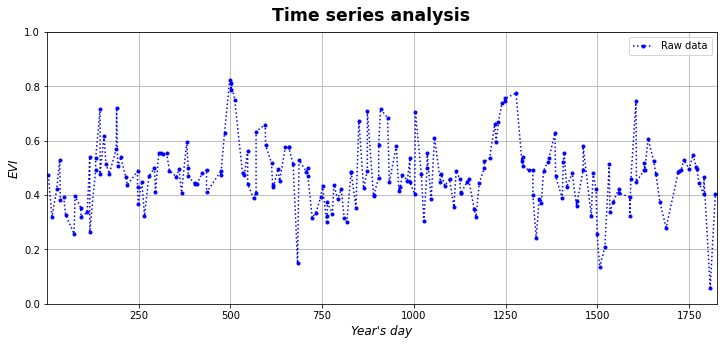

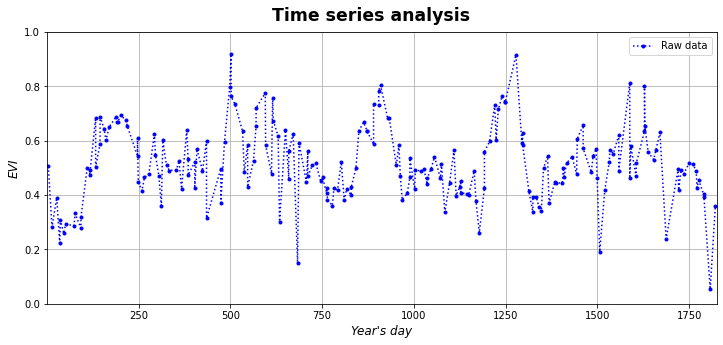

In [15]:
print ('2 pixels for 2017')
perPixel(modisData, 2, 'year')

print ('2 pixels from 2013 to 2017')
perPixel(squareModisData, 2, 'square')

## Treatments

### 1. Measured coordinates

In [16]:
def coords(modisData, path, quadratsData):
    """
        Use MODIS data and quadrats coordinates to plot coordinates of both system.
        It permits to verify the surface area of the work zone, the centering on the principal
        point and roughly the projection.
        
        :param modisData: MODIS data from prepareModisData()
        :param path: name of the path to the .txt MODIS data
        :param quadratsData: quadrats coordinates from prepareQuadratsData()
        :type modisData: numpy.ndarray
        :type path: str
        :type quadratsData: list(list, ..., list)
    """
    # Quadrat number search
    for name in (path.split('/')[-1]).split('_'):
        if 'square' in name:
            numQuadrat = int(name.replace('square',''))
            break
    
    # Treatment    
    transpose = modisData[1::].T
    xITM, yITM, xMODIS, yMODIS = transpose[1], transpose[2], transpose[3], transpose[4]
    
    xStatsITM = [min(xITM), max(xITM)]
    yStatsITM = [min(yITM), max(yITM)]
    xStatsMODIS = [min(xMODIS), max(xMODIS)]
    yStatsMODIS = [min(yMODIS), max(yMODIS)]    
    
    # Graphics
    fig = plt.figure(figsize=(12,9))
    
    plt.suptitle('Measured coordinates', size='xx-large', weight='bold', y=0.80)
    
    plt.subplot(121)
    plt.title('ITM', size='x-large', weight='bold')
    plt.plot(xITM, yITM, 'b.')
    plt.plot(quadratsData[numQuadrat][1], quadratsData[numQuadrat][2], 'mo', markersize=10)
    plt.xlabel('xITM', size='large', style='italic')
    plt.ylabel('yITM', size='large', style='italic')
    plt.grid()
    
    plt.gca().set_aspect(aspect='equal')
    axisStats = plt.axis()
    
    plt.plot([axisStats[0],axisStats[1]], [yStatsITM[0],yStatsITM[0]], 'r-')
    plt.plot([axisStats[0],axisStats[1]], [yStatsITM[1],yStatsITM[1]], 'r-')
    plt.plot([xStatsITM[0],xStatsITM[0]], [axisStats[2],axisStats[3]], 'r-')
    plt.plot([xStatsITM[1],xStatsITM[1]], [axisStats[2],axisStats[3]], 'r-')
    plt.text(axisStats[0], axisStats[3]-200, str(round(xStatsITM[0])) + ' ; '
                                         + str(round(yStatsITM[1])), weight='bold',
                                         bbox=dict(facecolor='red', alpha=0.5))
    plt.text(axisStats[1]-3000, axisStats[2], str(round(xStatsITM[1])) + ' ; '
                                         + str(round(yStatsITM[0])), weight='bold',
                                         bbox=dict(facecolor='red', alpha=0.5))
    
    plt.subplot(122)
    plt.title('MODIS', size='x-large', weight='bold')
    plt.plot(xMODIS, yMODIS, 'b.')
    plt.xlabel('xMODIS', size='large', style='italic')
    plt.ylabel('yMODIS', size='large', style='italic', rotation=-90, labelpad=15)
    plt.grid()
    
    plt.gca().yaxis.set_ticks_position('right')
    plt.gca().yaxis.set_label_position('right')
    plt.gca().set_aspect(aspect='equal')
    axisStats = plt.axis()
    
    plt.plot([axisStats[0],axisStats[1]], [yStatsMODIS[0],yStatsMODIS[0]], 'r-')
    plt.plot([axisStats[0],axisStats[1]], [yStatsMODIS[1],yStatsMODIS[1]], 'r-')
    plt.plot([xStatsMODIS[0],xStatsMODIS[0]], [axisStats[2],axisStats[3]], 'r-')
    plt.plot([xStatsMODIS[1],xStatsMODIS[1]], [axisStats[2],axisStats[3]], 'r-')
    plt.text(axisStats[0], axisStats[3]-200, str(round(xStatsMODIS[0])) + ' ; '
                                         + str(round(yStatsMODIS[1])), weight='bold',
                                         bbox=dict(facecolor='red', alpha=0.5))
    plt.text(axisStats[1]-3000, axisStats[2], str(round(xStatsMODIS[1])) + ' ; '
                                         + str(round(yStatsMODIS[0])), weight='bold',
                                         bbox=dict(facecolor='red', alpha=0.5))
    
    plt.show()

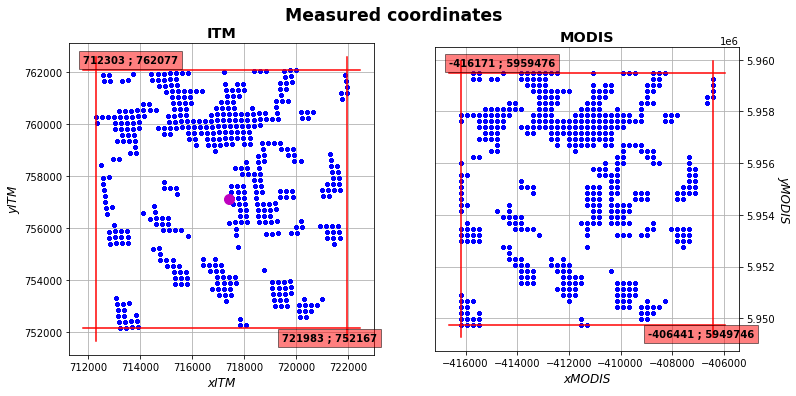

In [17]:
coords(modisData, filePath, quadratsCoordData)

### 2. Temporal autocorrelation

In [18]:
def temporalAutocorrelation(squareModisData):
    """
        Take the mean of measurements on each date because we need a constant time
        interval between two measures of 1 day.
        After, verify the possibility of the temporal autocorrelation on a quadrat with a 
        lag plot. That's to use with several years of data.
                
        :param squareModisData: MODIS measurements from several years
        :type squareModisData: list(prepareModisData(), ...)
    """
    
    modisData, nbYears = squareData(squareModisData)
    
    pandasData = pandas.DataFrame(data=modisData[1::], columns=modisData[0])

    pandasData['evi'] = pandas.to_numeric(pandasData['evi'])
    pandasData = pandasData.groupby('doy').evi.mean().reset_index()

    days = pandasData.doy.to_list()
    toAdd = []
    
    # Add NaN values on dates without measurements
    for i in range (min(days), max(days)):
        if i not in days:
            toAdd.append([i, np.nan])

    pandasAdd = pandas.DataFrame(data=toAdd, columns=['doy', 'evi'])

    pandasConcat = pandas.concat([pandasData, pandasAdd], ignore_index=True)
    pandasConcat = pandasConcat.sort_values(by='doy')
    pandasConcat = pandasConcat.reset_index(drop=True)

    eviSeries = pandas.Series(pandasConcat.evi)
    
    # Graphics
    plt.figure(figsize=(12, 6))
    plt.suptitle('Temporal autocorrellation', size='xx-large', weight='bold', y=0.95)
    
    pandas.plotting.lag_plot(eviSeries, lag=365)
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.gca().set_aspect(aspect='equal')
    plt.grid()
    
    plt.show()

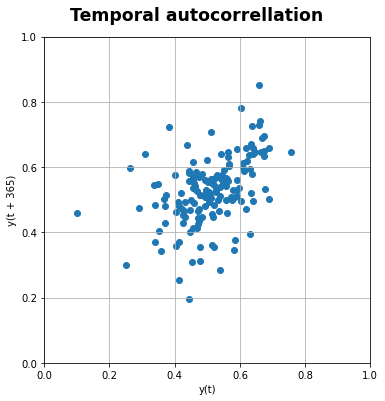

In [19]:
temporalAutocorrelation(squareModisData)

### 3. Heat maps

In [20]:
def shadeCoords(filteredModisData):
    """
        Use MODIS data to plot coordinates with 'rainbow' shade of EVI measures.
        The aim is to look if there's parcels with similarities.
                
        :param filteredModisData: MODIS data from monthlyModisData() (xMODIS, yMODIS, ndvi, evi, forMonth)
        :type filteredModisData: numpy.ndarray
    """
    # Treatment
    xMODIS, yMODIS, ndvi, evi, forMonth = filteredModisData
    xMin, xMax, yMin, yMax = min(xMODIS), max(xMODIS), min(yMODIS), max(yMODIS)
        
    for values in forMonth:

        x, y, e = [], [], []
                
        for index in values[1]:
            x.append(xMODIS[index])
            y.append(yMODIS[index])
            e.append(evi[index])
        
        # Graphics
        cm = plt.cm.get_cmap('jet')
        
        fig, axes = plt.subplots(figsize=(12,6))
        plt.suptitle("                 Nuanced coordinates to identify neighborhood ({})".format(values[0]), size='xx-large', weight='bold')
        
        plt.scatter(x, y, c=e, marker='.', s=150, edgecolor='none', cmap=cm, vmin=0, vmax=1)
        plt.xlabel('xMODIS', size='large', style='italic')
        plt.ylabel('yMODIS', size='large', style='italic', labelpad=15)
        plt.xlim(xMin-200, xMax+200)
        plt.ylim(yMin-200, yMax+200)
        plt.grid()
        
        plt.gca().set_aspect(aspect='equal')
        
        sm = plt.cm.ScalarMappable(cmap=cm)        
        fig.colorbar(sm, ax=axes)
        
        plt.show()
        
        print ('\n\n')

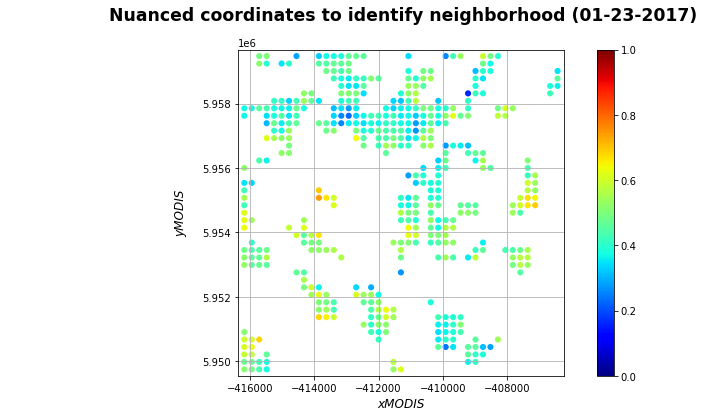

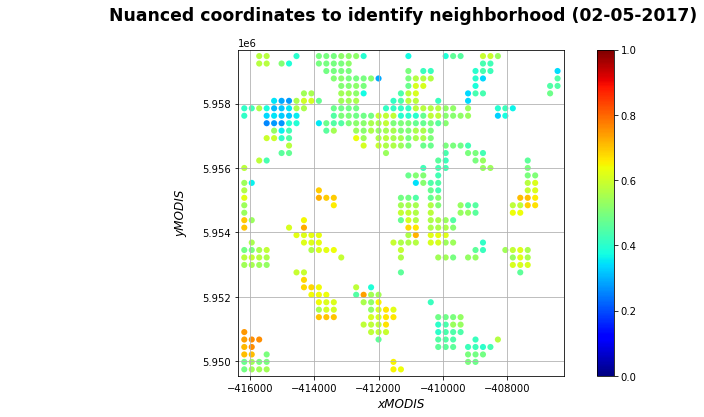

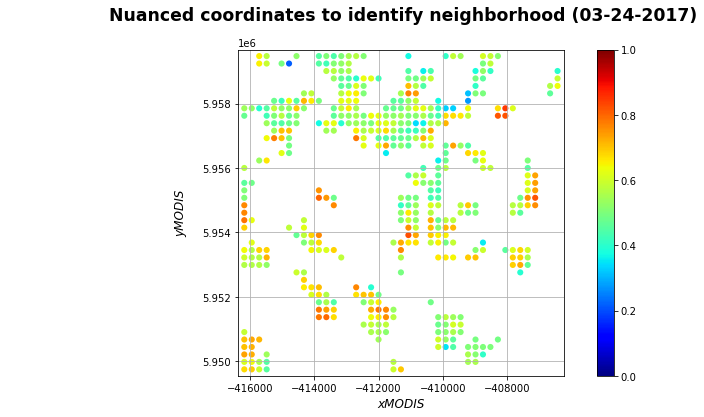

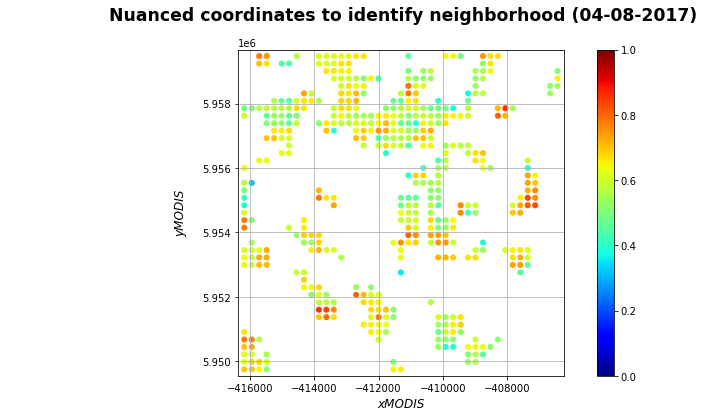

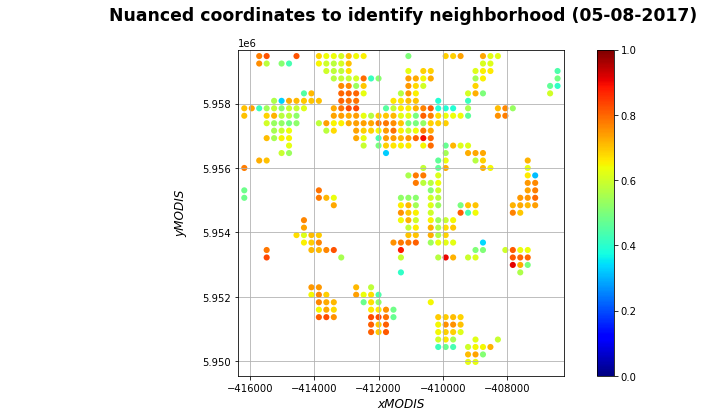

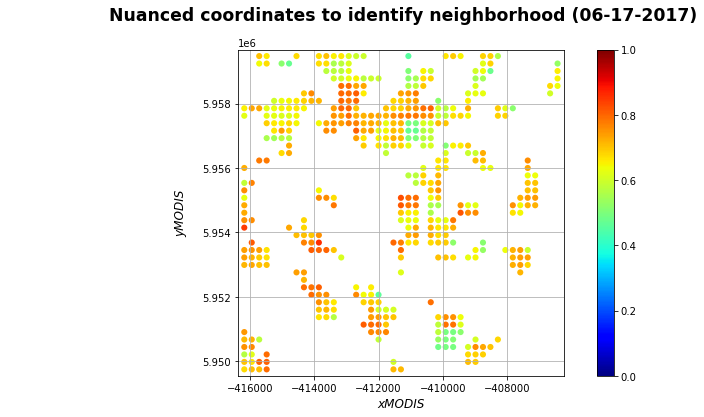

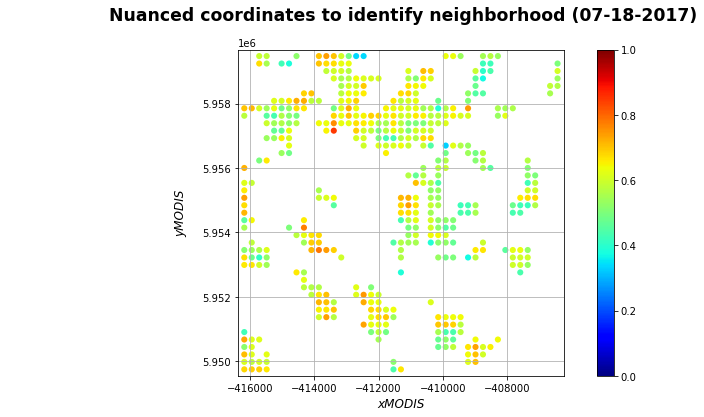

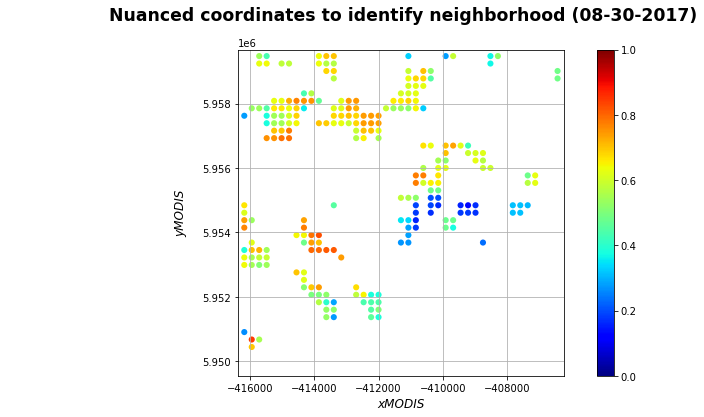

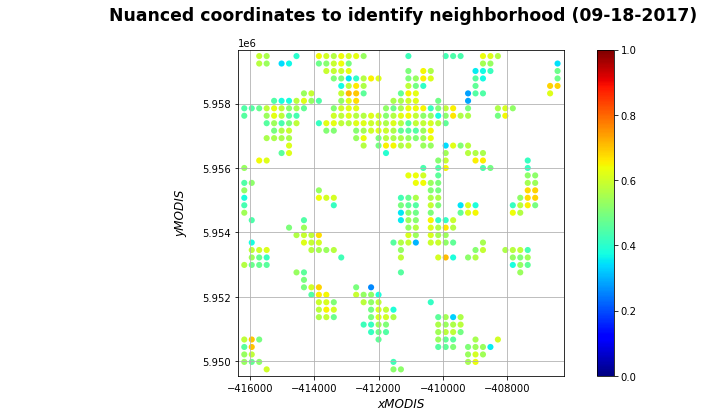

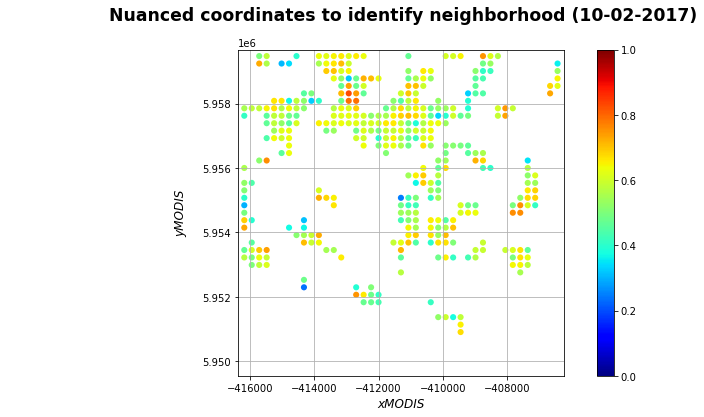

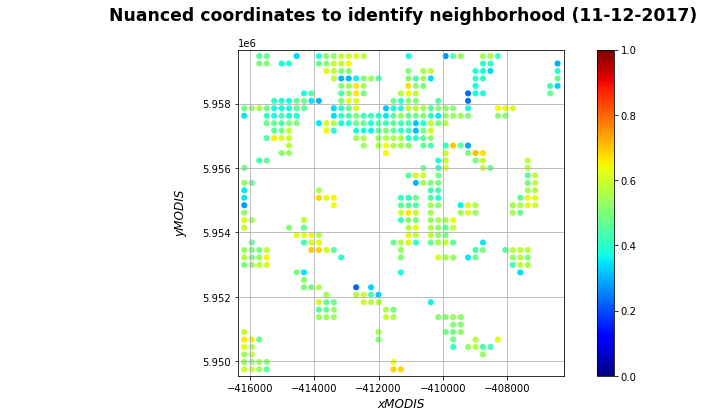

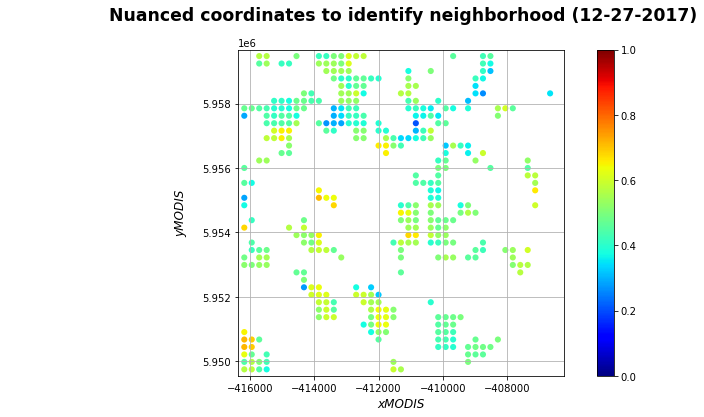

In [21]:
shadeCoords(filteredModisData)

### 4. Semivariograms

In [22]:
# environment variable isn't working and warning still appears
%set_env SKG_SUPPRESS=true

def semivariogram(filteredModisData):
    """
        Calculate semivariograms with spherical model which is default one.
        
        :param filteredModisData: MODIS data from monthlyModisData() (xMODIS, yMODIS, ndvi, evi, forMonth)
        :type filteredModisData: tuple(list, list, list, list, list)
    """
    # Treatment
    xMODIS, yMODIS, ndvi, evi, forMonth = filteredModisData
    
    for values in forMonth:
        
        x, y, e = [], [], []
                
        for index in values[1]:
            x.append(xMODIS[index])
            y.append(yMODIS[index])
            e.append(evi[index])
        
        coords = []
        for i in range (len(x)):
            coords.append((x[i],y[i]))
        
        # Calculate variogram models
        eviSph = Variogram(coords, e, bin_func='even', normalize=False, n_lags=25,
                           fit_method='trf', dist_func='euclidean', use_nugget=False, maxlag=10000)
        
        # Graphics
        fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12,5))
        plt.suptitle('Variogram ({})'.format(values[0]), size='x-large', weight='bold', y=1.03)
        
        eviSph.distance_difference_plot(ax=ax[0], plot_bins=True, show=False)
        
        plt.title('Semivariogram')
        eviSph.plot(axes=ax[1], grid=True, show=False, hist=True)
        
        fig.tight_layout(w_pad=5)
        
        plt.show()
        
        print ('\n\n')

env: SKG_SUPPRESS=true


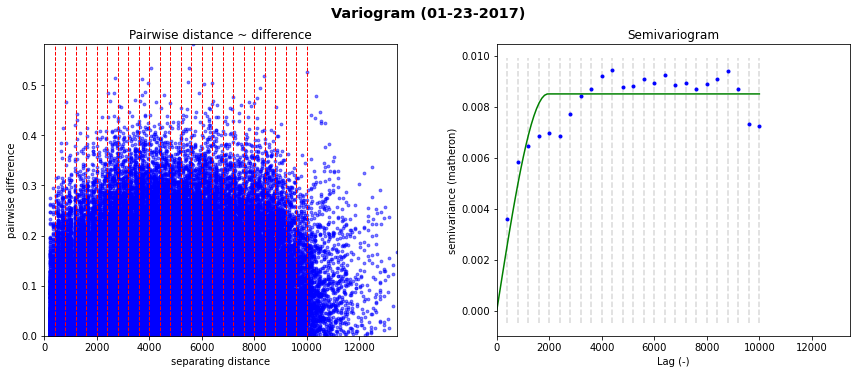

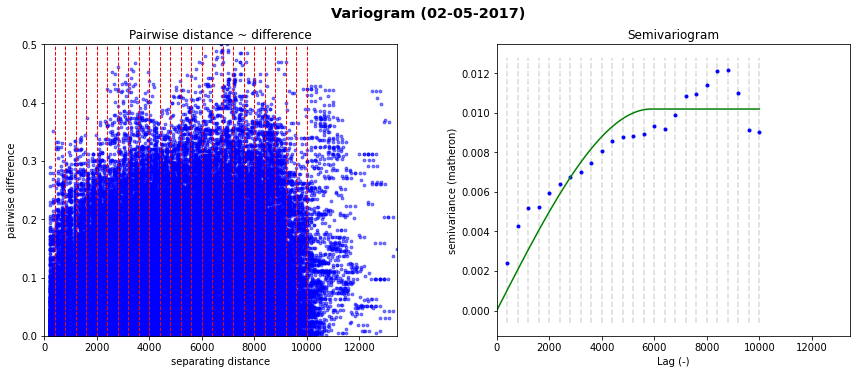

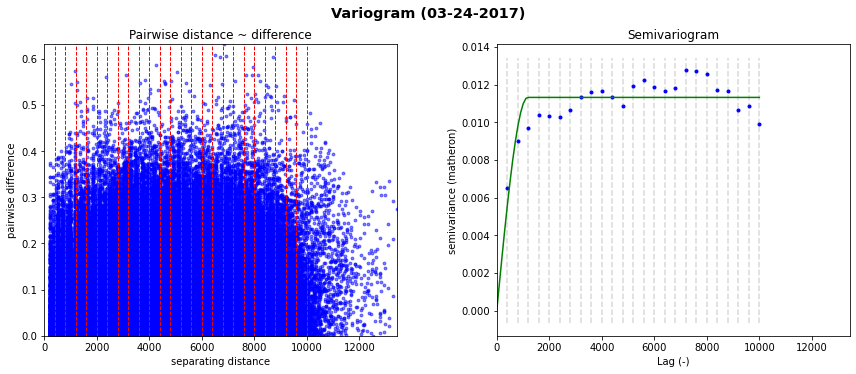

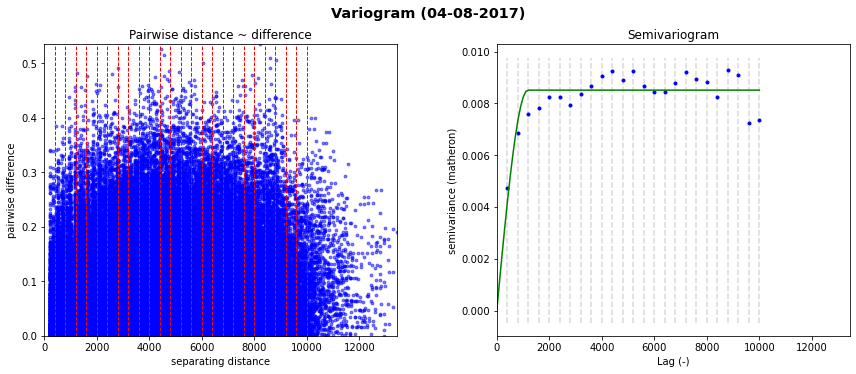

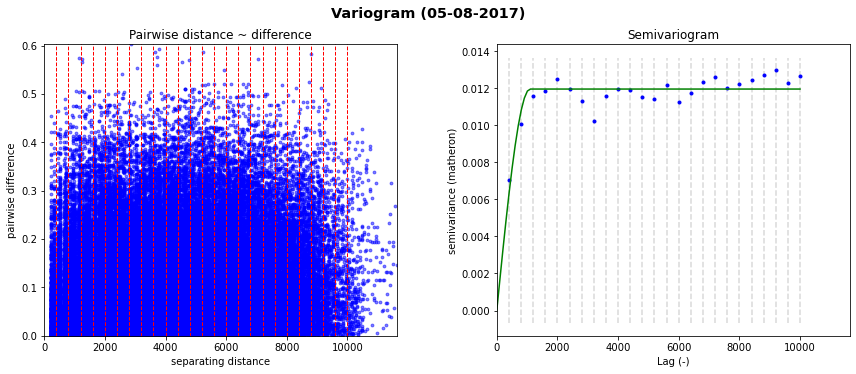

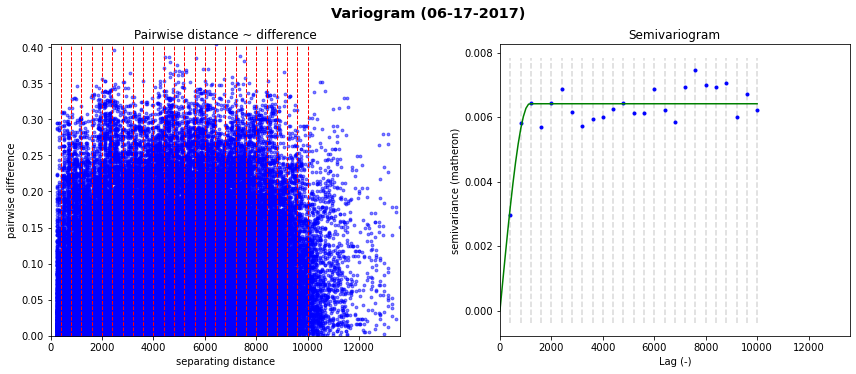

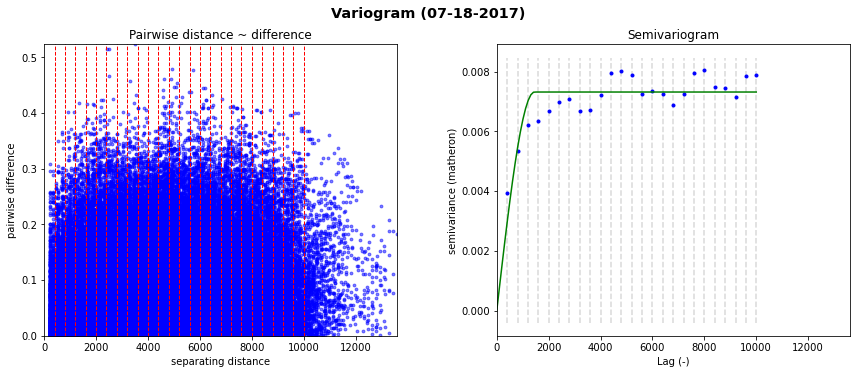

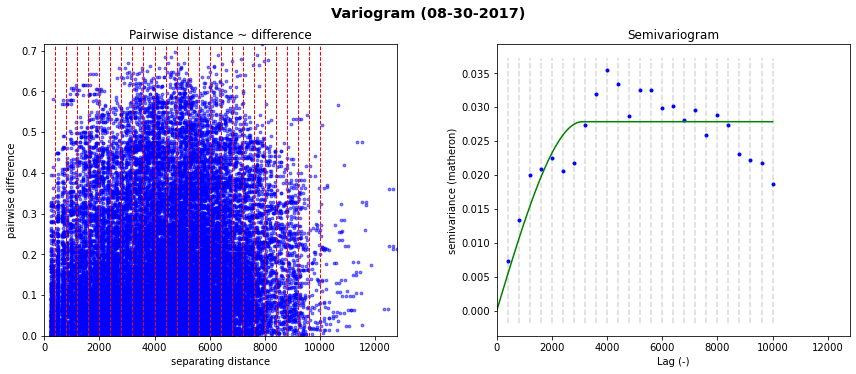

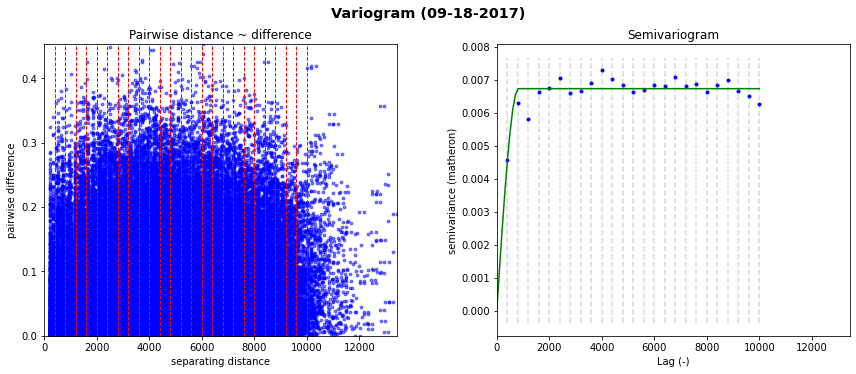

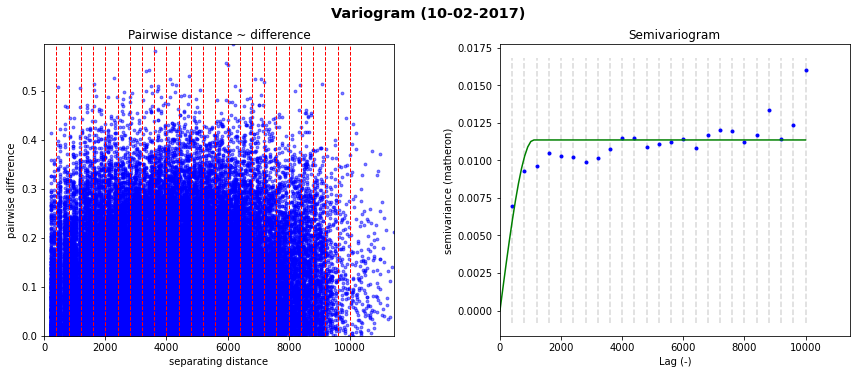

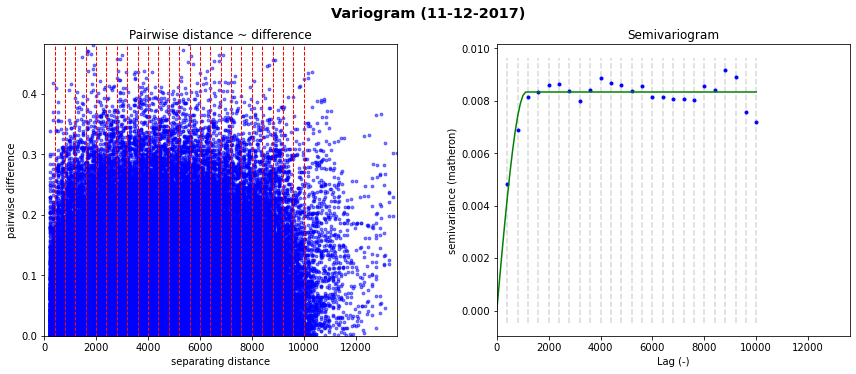

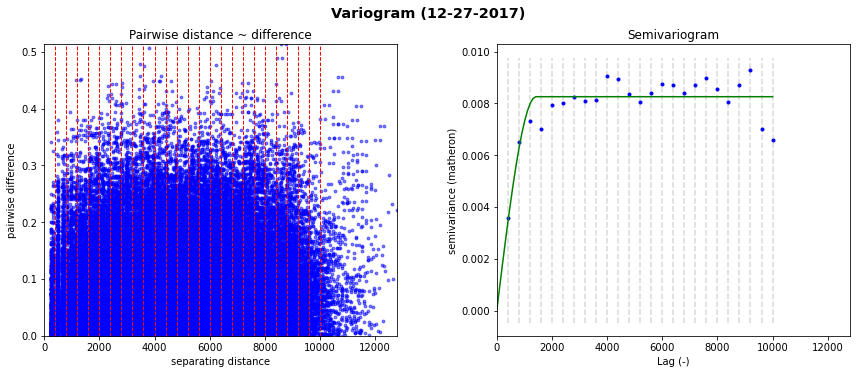

In [23]:
semivariogram(filteredModisData)

### 5. Moran indice

In [24]:
def spatialAutocorrelation(filteredModisData):
    """
        Calculate global spatial autocorrelation with a distance band of 1000 meters.
        Helped by http://darribas.org/gds_scipy16/ipynb_md/04_esda.html
        
        :param filteredModisData: MODIS data from monthlyModisData() (xMODIS, yMODIS, ndvi, evi, forMonth)
        :type filteredModisData: tuple(list, list, list, list, list)
    """
    # Treatment
    xMODIS, yMODIS, ndvi, evi, forMonth = filteredModisData
    xMin, xMax, yMin, yMax = min(xMODIS), max(xMODIS), min(yMODIS), max(yMODIS)
    
    for values in forMonth:
                
        x, y, e = [], [], []
                
        for index in values[1]:
            x.append(xMODIS[index])
            y.append(yMODIS[index])
            e.append(evi[index])
        
        points = []
        for i in range (len(x)):
            points.append(Point(x[i],y[i]))
        
        dfPoints = pandas.DataFrame(points, columns=['geometry'])
        
        wDistance = lps.weights.DistanceBand.from_dataframe(dfPoints, threshold=1000, geom_col='geometry', ids=None, binary=True)
        wDistance.transform = 'r'
        
        eviSeries = pandas.DataFrame(e, columns=['EVI'])
        eviLag = lps.weights.lag_spatial(wDistance, eviSeries['EVI'])
        
        I = ps.explore.esda.moran.Moran(eviSeries.values, wDistance)
        print ("Calculated Moran indice with pysal library: {}".format(I.I))
        
        # Graphics
        moranPlot(values[0], e, eviLag, x, y)
        
        # Graphics with autocorrelated values : not interesting
        #cm = plt.cm.get_cmap('jet')
        #
        #fig, axes = plt.subplots(1, 2, figsize=(12,9), dpi=200)
        #plt.suptitle("Nuanced coordinates after spatial autocorrelation", size='xx-large', weight='bold', y=0.80)
        #
        #plt.subplot(121)
        #plt.scatter(x, y, c=ndviLag, marker='.', s=150, edgecolor='none', cmap=cm, vmin=0, vmax=1)
        #plt.title('NDVI', size='x-large', weight='bold')
        #plt.xlabel('xMODIS', size='large', style='italic')
        #plt.ylabel('yMODIS', size='large', style='italic')
        #plt.xlim(xMin-200, xMax+200)
        #plt.ylim(yMin-200, yMax+200)
        #plt.grid()
        #
        #plt.gca().set_aspect(aspect='equal')
        #
        #plt.subplot(122)
        #plt.figure()
        #plt.scatter(x, y, c=eviLag, marker='.', s=150, edgecolor='none', cmap=cm, vmin=0, vmax=1)
        #plt.title('EVI', size='x-large', weight='bold')
        #plt.xlabel('xMODIS', size='large', style='italic')
        #plt.ylabel('yMODIS', size='large', style='italic', rotation=-90, labelpad=15)
        #plt.xlim(xMin-200, xMax+200)
        #plt.ylim(yMin-200, yMax+200)
        #plt.grid()
        #
        #plt.gca().set_aspect(aspect='equal')
        #plt.gca().yaxis.set_ticks_position('right')
        #plt.gca().yaxis.set_label_position('right')
        #
        #sm = plt.cm.ScalarMappable(cmap=cm)
        #fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.52, shrink=0.5)
        #
        #plt.show()

In [25]:
def moranPlot(doy, evi, eviLag, xMODIS, yMODIS):
    """
        Create a Moran plot with calculated values.
        Used in spatialAutocorrelation() function.
        
        :param doy: the used day
        :param evi: list of EVI measures
        :param eviLag: list of EVI spatially autocorrelated values
        :param xMODIS: list of measured coordinates
        :param yMODIS: list of measured coordinates
        :type doy: str
        :type evi: list
        :type eviLag: list
        :type xMODIS: list
        :type yMODIS: list
    """    
    # Treatment
    bEvi, aEvi = np.polyfit(evi, eviLag, 1)
    eviFit = [(aEvi + bEvi * e) for e in evi]
    
    # Graphics
    plt.figure(figsize=(10, 7))
    
    plt.suptitle("Moran scatter plot ({})".format(doy), size='xx-large', weight='bold', y=0.95)
    
    plt.plot(evi, eviLag, 'b.', markersize=3)
    plt.plot(evi, eviFit, 'r', label='Slope = {}'.format(str(bEvi)))
    plt.vlines(np.mean(evi), 0, 1, linestyle='--')
    plt.hlines(np.mean(eviLag), 0, 1, linestyle='--')
    plt.xlabel('EVI', size='large', style='italic')
    plt.ylabel('Spatial lag EVI', size='large', style='italic')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc='lower right', framealpha=0.8)
    plt.grid()
    
    plt.gca().set_aspect(aspect='equal')
    
    plt.show()
    
    print ('\n\n')

Calculated Moran indice with pysal library: 0.32135019511707696


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


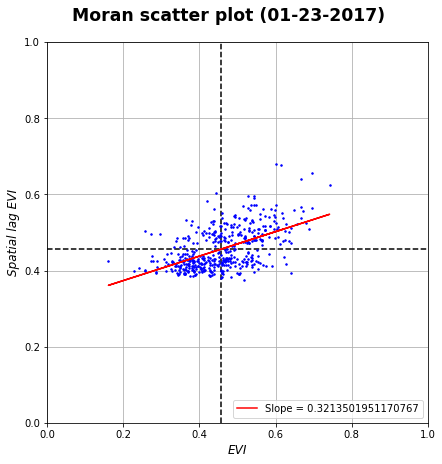




Calculated Moran indice with pysal library: 0.5071995006836503


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


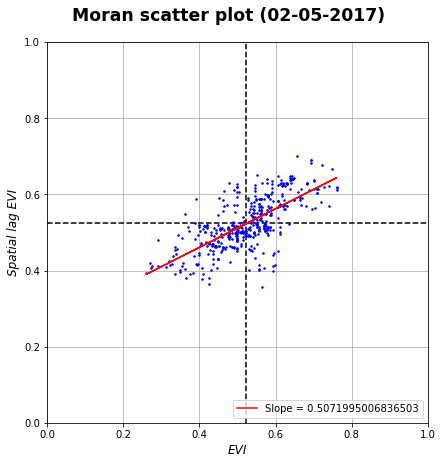




Calculated Moran indice with pysal library: 0.1982734409107188


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


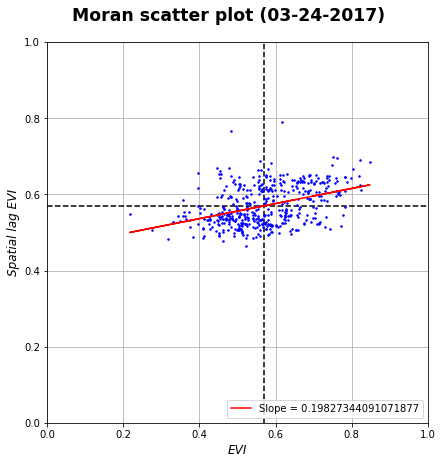




Calculated Moran indice with pysal library: 0.16256681975794568


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


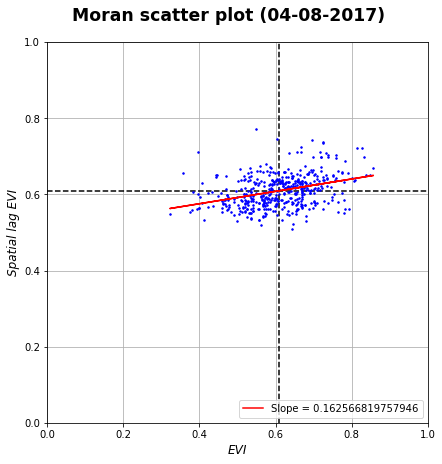




Calculated Moran indice with pysal library: 0.12753738904945844


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


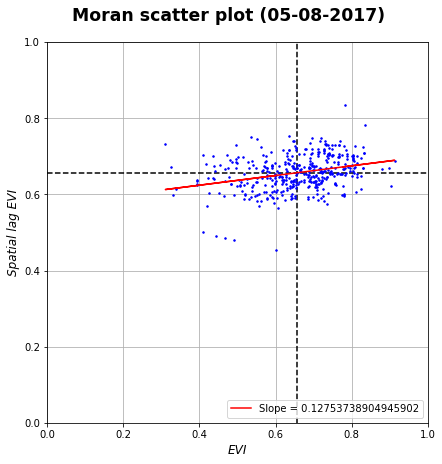




Calculated Moran indice with pysal library: 0.21145449815513323


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


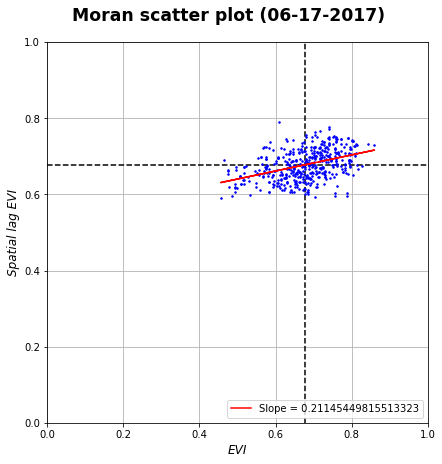




Calculated Moran indice with pysal library: 0.20282795630810868


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


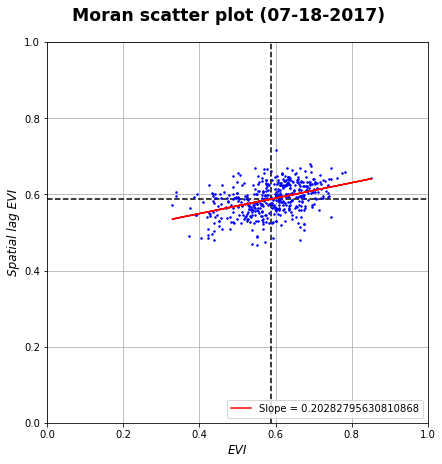




('WARNING: ', 183, ' is an island (no neighbors)')
Calculated Moran indice with pysal library: 0.5101892963797228


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There is 1 island with id: 183.
  warnings.warn(message)


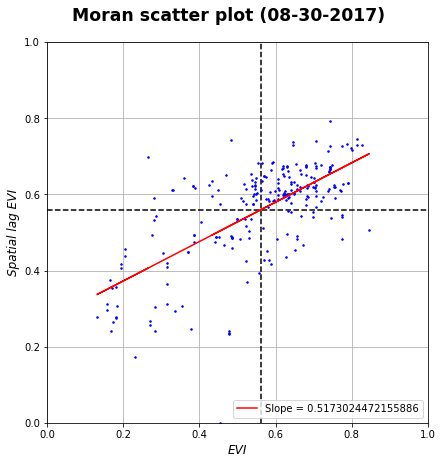




Calculated Moran indice with pysal library: 0.05817885563125014


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


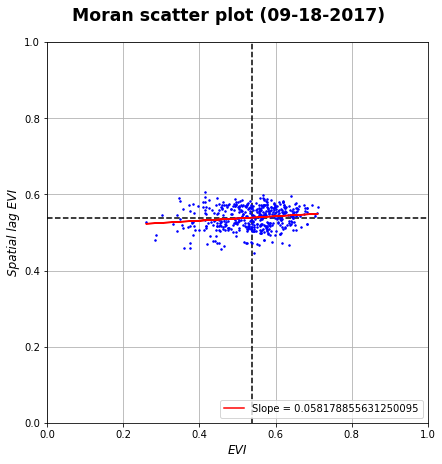




Calculated Moran indice with pysal library: 0.09710925430748747


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


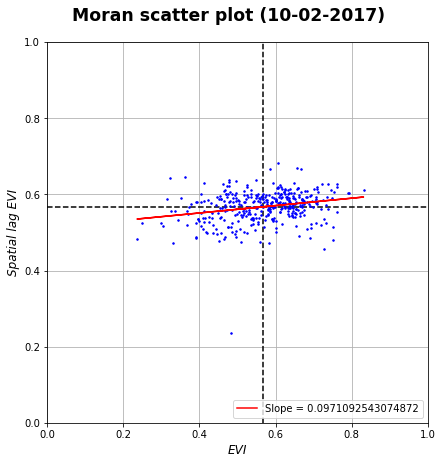




Calculated Moran indice with pysal library: 0.1857907521333746


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


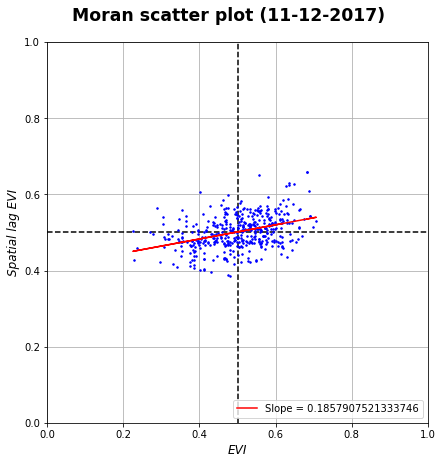




('WARNING: ', 279, ' is an island (no neighbors)')
Calculated Moran indice with pysal library: 0.2813414560641721


C:\Users\gabin\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There is 1 island with id: 279.
  warnings.warn(message)


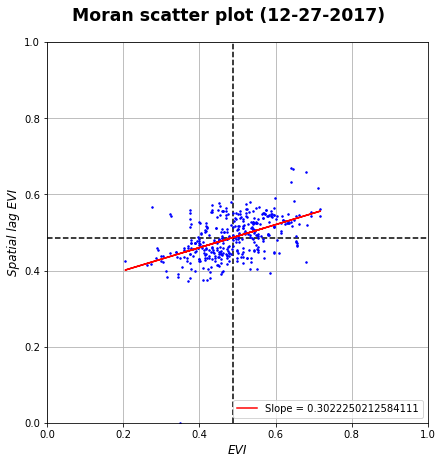

In [26]:
spatialAutocorrelation(filteredModisData)

In [27]:
def distanceBand(filteredModisData):
    """
        Look at global Moran's I with different distances weight to identify
        the better distance band.
        
        :param filteredModisData: MODIS data from monthlyModisData()
                                  (xMODIS, yMODIS, ndvi, evi, forMonth)
        :type filteredModisData: tuple(list, list, list, list, list)
"""
    # Treatment
    xMODIS, yMODIS, ndvi, evi, forMonth = filteredModisData
    xMin, xMax, yMin, yMax = min(xMODIS), max(xMODIS), min(yMODIS), max(yMODIS)
    
    for values in forMonth:
        
        x, y, e = [], [], []
        
        for index in values[1]:
            x.append(xMODIS[index])
            y.append(yMODIS[index])
            e.append(evi[index])
        
        points = []
        for i in range (len(x)):
            points.append(Point(x[i],y[i]))
        
        dfPoints = pandas.DataFrame(points, columns=['geometry'])
        
        distances = np.arange(250, 10250, 250)
        wDistances = []
        eviMoran = []
        
        for distance in distances:
            wDistances.append(lps.weights.DistanceBand.from_dataframe(dfPoints, threshold=distance,
                                                        geom_col='geometry', ids=None, binary=True))
                        
            eviSeries = pandas.DataFrame(e, columns=['EVI'])
            eviMoran.append(ps.explore.esda.moran.Moran(eviSeries['EVI'], wDistances[-1]))
        
        eviI, eviZ, eviP = [], [], []
        
        for i in range (len(eviMoran)):
            eviI.append(eviMoran[i].I)
            eviZ.append(eviMoran[i].z_norm)
            eviP.append(eviMoran[i].p_norm)
            
        # Graphics
        fig = plt.figure(figsize=(12,5))
        
        plt.suptitle("Moran statistics on EVI measurements ({})".format(values[0]), size='xx-large', weight='bold', y=1.03)
        
        plt.subplot(131)
        plt.plot(distances, eviI, 'b:o', label="Moran's I")
        plt.xlabel("Distance band", size='large', style='italic')
        plt.xlim(0, 10000)
        plt.ylim(-0.1, 1)
        plt.legend(loc='upper right', framealpha=0.8)
        plt.grid()
        
        plt.subplot(132)
        plt.plot(distances, eviZ, 'r:o', label="Z-value")
        plt.xlabel("Distance band", size='large', style='italic')
        plt.xlim(0, 10000)
        plt.ylim(-5, 25)
        plt.legend(loc='upper right', framealpha=0.8)
        plt.grid()        
        
        plt.subplot(133)
        plt.plot(distances, eviP, 'g:o', label="P-value")
        plt.xlabel("Distance band", size='large', style='italic')
        plt.xlim(0, 10000)
        plt.ylim(-0.1, 1)
        plt.legend(loc='upper right', framealpha=0.8)
        plt.grid()
        
        fig.tight_layout(pad=1.5)
        
        plt.show()
        
        print ('\n\n')

('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 226, ' is an island (no neighbors)')
('WARNING: ', 300, ' is an island (no neighbors)')
('WARNING: ', 349, ' is an island (no neighbors)')
('WARNING: ', 368, ' is an island (no neighbors)')
('WARNING: ', 389, ' is an island (no neighbors)')
('WARNING: ', 432, ' is an island (no neighbors)')
('WARNING: ', 389, ' is an island (no neighbors)')


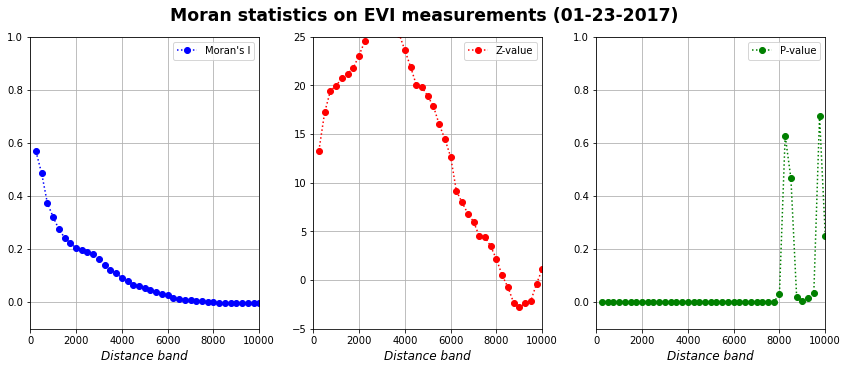




('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 199, ' is an island (no neighbors)')
('WARNING: ', 273, ' is an island (no neighbors)')
('WARNING: ', 322, ' is an island (no neighbors)')
('WARNING: ', 341, ' is an island (no neighbors)')
('WARNING: ', 362, ' is an island (no neighbors)')
('WARNING: ', 405, ' is an island (no neighbors)')
('WARNING: ', 362, ' is an island (no neighbors)')


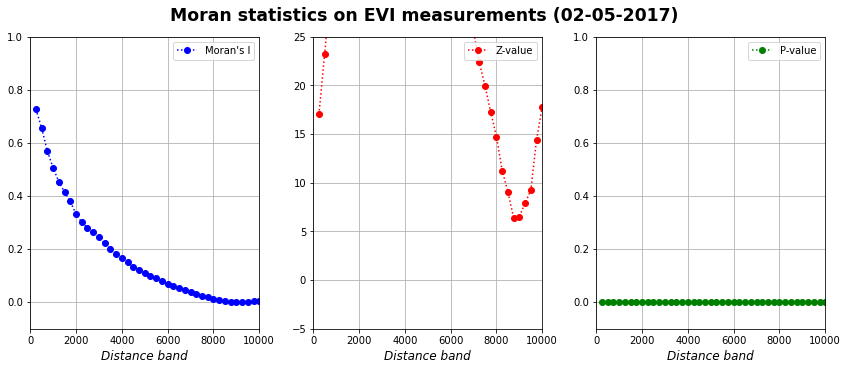




('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 300, ' is an island (no neighbors)')
('WARNING: ', 349, ' is an island (no neighbors)')
('WARNING: ', 368, ' is an island (no neighbors)')
('WARNING: ', 389, ' is an island (no neighbors)')
('WARNING: ', 432, ' is an island (no neighbors)')
('WARNING: ', 389, ' is an island (no neighbors)')


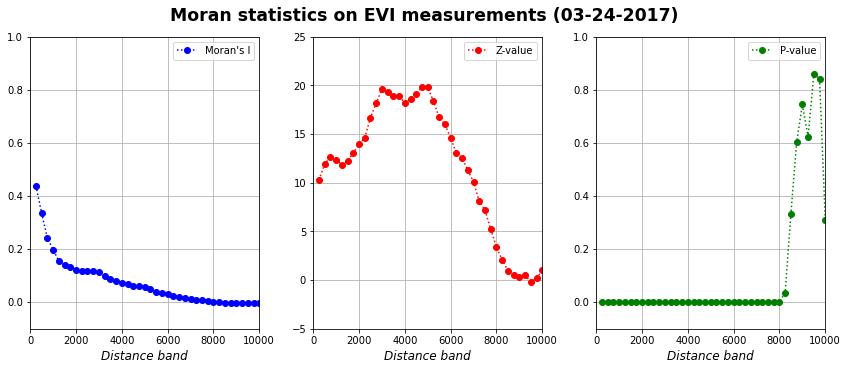




('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 262, ' is an island (no neighbors)')
('WARNING: ', 336, ' is an island (no neighbors)')
('WARNING: ', 376, ' is an island (no neighbors)')
('WARNING: ', 390, ' is an island (no neighbors)')
('WARNING: ', 406, ' is an island (no neighbors)')
('WARNING: ', 435, ' is an island (no neighbors)')
('WARNING: ', 406, ' is an island (no neighbors)')


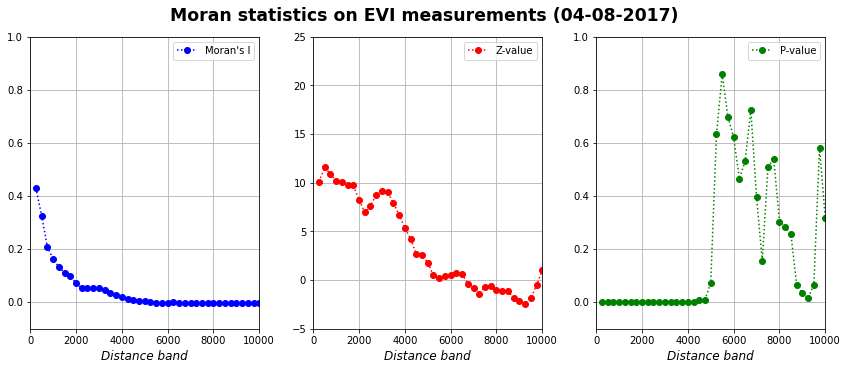




('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 180, ' is an island (no neighbors)')
('WARNING: ', 195, ' is an island (no neighbors)')
('WARNING: ', 226, ' is an island (no neighbors)')
('WARNING: ', 299, ' is an island (no neighbors)')
('WARNING: ', 394, ' is an island (no neighbors)')
('WARNING: ', 195, ' is an island (no neighbors)')
('WARNING: ', 299, ' is an island (no neighbors)')


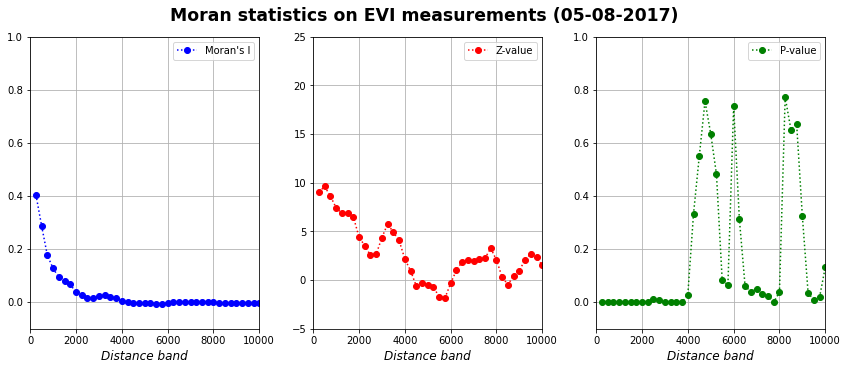




('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 227, ' is an island (no neighbors)')
('WARNING: ', 301, ' is an island (no neighbors)')
('WARNING: ', 350, ' is an island (no neighbors)')
('WARNING: ', 369, ' is an island (no neighbors)')
('WARNING: ', 390, ' is an island (no neighbors)')
('WARNING: ', 433, ' is an island (no neighbors)')
('WARNING: ', 390, ' is an island (no neighbors)')


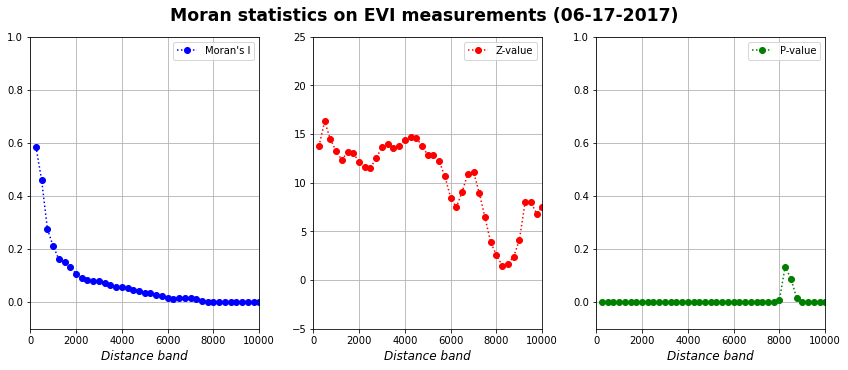




('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 193, ' is an island (no neighbors)')
('WARNING: ', 210, ' is an island (no neighbors)')
('WARNING: ', 240, ' is an island (no neighbors)')
('WARNING: ', 315, ' is an island (no neighbors)')
('WARNING: ', 368, ' is an island (no neighbors)')
('WARNING: ', 423, ' is an island (no neighbors)')
('WARNING: ', 210, ' is an island (no neighbors)')


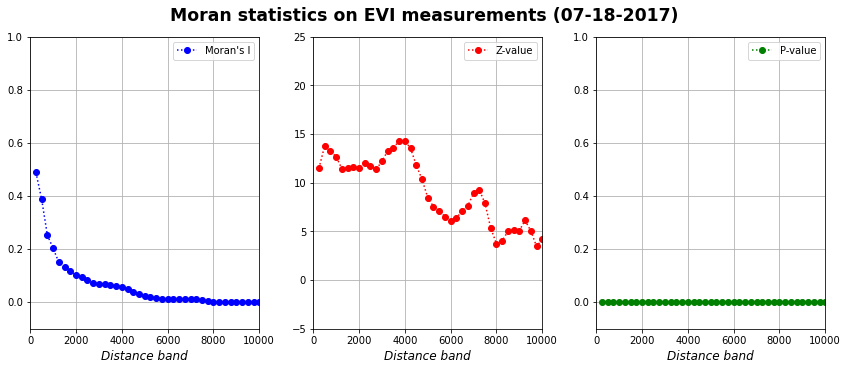




('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 57, ' is an island (no neighbors)')
('WARNING: ', 179, ' is an island (no neighbors)')
('WARNING: ', 183, ' is an island (no neighbors)')
('WARNING: ', 211, ' is an island (no neighbors)')
('WARNING: ', 241, ' is an island (no neighbors)')
('WARNING: ', 179, ' is an island (no neighbors)')
('WARNING: ', 183, ' is an island (no neighbors)')
('WARNING: ', 179, ' is an island (no neighbors)')
('WARNING: ', 183, ' is an island (no neighbors)')
('WARNING: ', 183, ' is an island (no neighbors)')


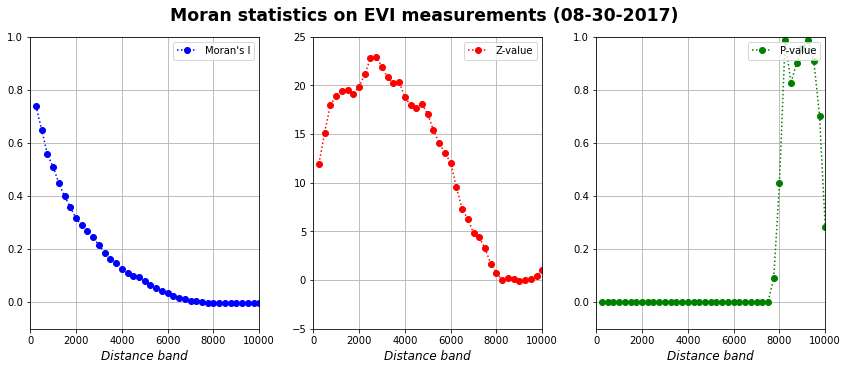




('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 239, ' is an island (no neighbors)')
('WARNING: ', 248, ' is an island (no neighbors)')
('WARNING: ', 295, ' is an island (no neighbors)')
('WARNING: ', 314, ' is an island (no neighbors)')
('WARNING: ', 333, ' is an island (no neighbors)')
('WARNING: ', 375, ' is an island (no neighbors)')
('WARNING: ', 396, ' is an island (no neighbors)')
('WARNING: ', 436, ' is an island (no neighbors)')
('WARNING: ', 333, ' is an island (no neighbors)')


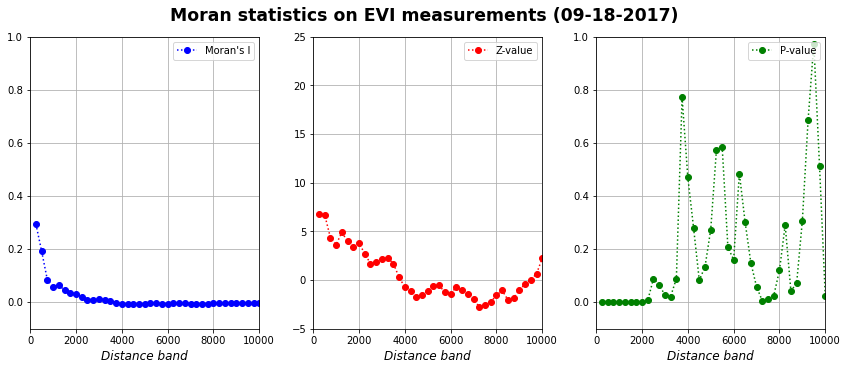




('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 203, ' is an island (no neighbors)')
('WARNING: ', 250, ' is an island (no neighbors)')
('WARNING: ', 296, ' is an island (no neighbors)')
('WARNING: ', 312, ' is an island (no neighbors)')
('WARNING: ', 325, ' is an island (no neighbors)')
('WARNING: ', 363, ' is an island (no neighbors)')
('WARNING: ', 325, ' is an island (no neighbors)')


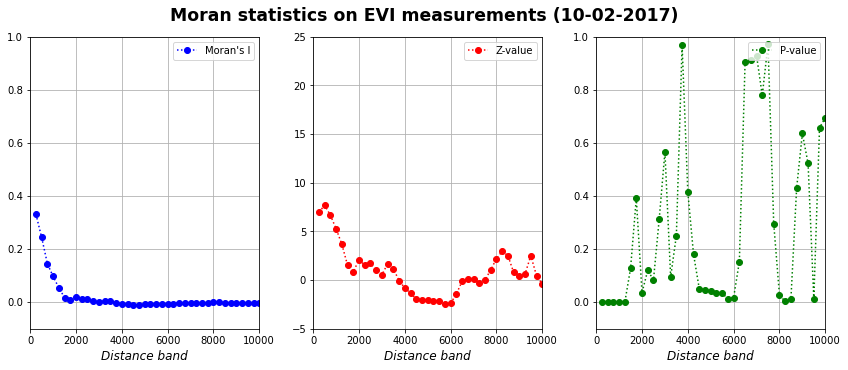




('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 55, ' is an island (no neighbors)')
('WARNING: ', 265, ' is an island (no neighbors)')
('WARNING: ', 326, ' is an island (no neighbors)')
('WARNING: ', 366, ' is an island (no neighbors)')
('WARNING: ', 379, ' is an island (no neighbors)')
('WARNING: ', 396, ' is an island (no neighbors)')
('WARNING: ', 421, ' is an island (no neighbors)')
('WARNING: ', 396, ' is an island (no neighbors)')


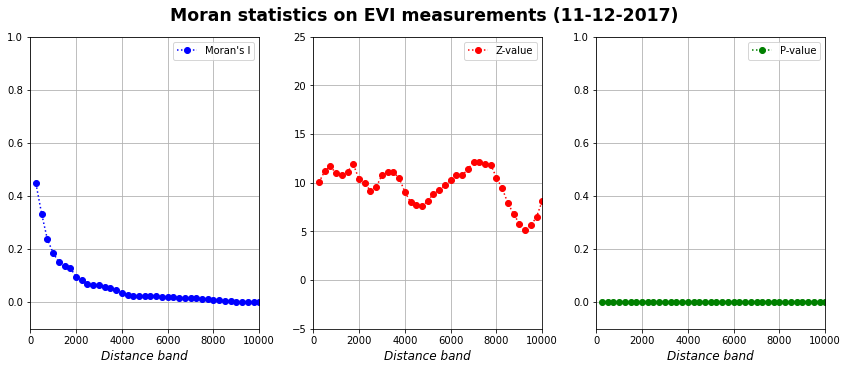




('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 119, ' is an island (no neighbors)')
('WARNING: ', 142, ' is an island (no neighbors)')
('WARNING: ', 177, ' is an island (no neighbors)')
('WARNING: ', 194, ' is an island (no neighbors)')
('WARNING: ', 215, ' is an island (no neighbors)')
('WARNING: ', 265, ' is an island (no neighbors)')
('WARNING: ', 268, ' is an island (no neighbors)')
('WARNING: ', 279, ' is an island (no neighbors)')
('WARNING: ', 282, ' is an island (no neighbors)')
('WARNING: ', 313, ' is an island (no neighbors)')
('WARNING: ', 314, ' is an island (no neighbors)')
('WARNING: ', 316, ' is an island (no neighbors)')
('WARNING: ', 338, ' is an island (no neighbors)')
('WARNING: ', 342, ' is an island (no neighbors)')
('WARNING: ', 345, ' is an island (no neighbors)')
('WARNING: ', 352, ' is an island (no neighbors)')
('WARNING: ', 357, ' is an island (no neighbors)')
('WARNING: ', 215, ' is an island (no neighbors)')
('WARNING: ', 265, ' is an isl

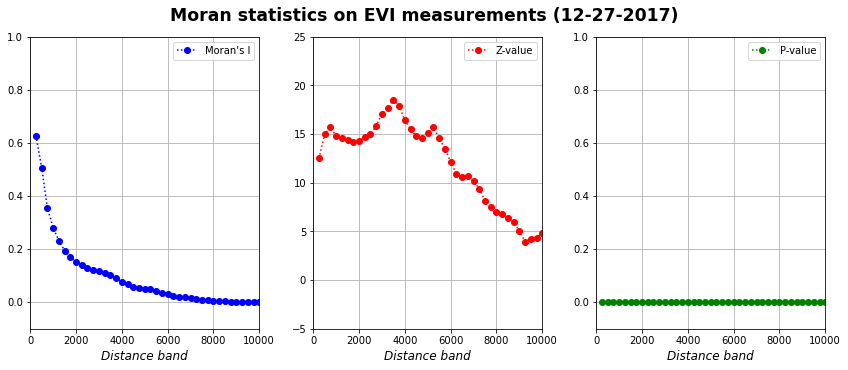

In [28]:
# Too much warnings for islands
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    distanceBand(filteredModisData)